# Time Series Data Analysis and Revenue Prediction with Michine Learning   

### -- AI-Enterprise-Workflow Professional certificate Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Source](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Feature Enginnering](#feature) 
* [Modelling](#modelling)
* [Results and Discussion](#results)

## Part 1. Introdiction: Business Problem<a name="introduction"></a>

As a video service company similar to NETFLIX, AAVAIL launched using a tiered, subscription-based service which showed promise, but conversations with users, especially those outside of US markets, prompted an experiment using an new approach. This experiment was carried out mostly outside of the US and there are now a couple of years of data with a few thousand active users. The data are transaction-level purchases across 38 different countries and are invoiced in batches. Management has nearly decided to make the switch to the new model, but they find it difficult to predict monthly revenue. 

The aim of this project is first to do the data analysis on the current database and then build a model that, at any point in time, to predict the revenue for the following month. The management also want the model to be able to project revenue for the top ten countries with the most revenue.

At last, for easy applying by other team with less IT skills like the marketing team, the management needs a API to automate the whole process, from extracting relevant data from multiple data sources to model dployment for revenue prediction.




## Part 2. Data Source<a name="data"></a>
The data for this case study come from the online retail data set and are available through the UCI Machine Learning Repository. The original data were published as a study that used RFM model to explore customer segmentation in the data set [1]. The data presented in this study are derived from this data set with simulated features and re-named columns to align with the AAVAIL case study. The dataset are a couple of jason files with details of the transaction from the customer since 2017

In [0]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_dir='/content/drive/My Drive/Colab Notebooks/IBM AI-workflow-capstone-master/cs-train'
file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]

## read data into a temp structure
all_months = {}
for file_name in file_list:
    df = pd.read_json(file_name)
    all_months[os.path.split(file_name)[-1]] = df

In [0]:
all_months

{'invoices-2017-11.json':              country  customer_id invoice  ...  year month  day
 0     United Kingdom      13085.0  489434  ...  2017    11   28
 1     United Kingdom          NaN  489597  ...  2017    11   28
 2     United Kingdom          NaN  489597  ...  2017    11   28
 3     United Kingdom          NaN  489597  ...  2017    11   28
 4     United Kingdom          NaN  489597  ...  2017    11   28
 ...              ...          ...     ...  ...   ...   ...  ...
 9497  United Kingdom      13895.0  490052  ...  2017    11   30
 9498  United Kingdom      16779.0  490048  ...  2017    11   30
 9499  United Kingdom      13895.0  490052  ...  2017    11   30
 9500  United Kingdom      13895.0  490052  ...  2017    11   30
 9501  United Kingdom      13895.0  490052  ...  2017    11   30
 
 [9502 rows x 9 columns],
 'invoices-2017-12.json':               country  customer_id invoice  ...  year month  day
 0      United Kingdom      13162.0  490297  ...  2017    12    1
 1      Un

In [0]:
df = pd.concat(list(all_months.values()))
df

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,StreamID,TimesViewed,total_price
0,United Kingdom,17841.0,555562,1.95,22659,1.0,2019,6,2,NaN,NaN,NaN
1,United Kingdom,17841.0,555562,0.55,21975,5.0,2019,6,2,NaN,NaN,NaN
2,United Kingdom,17841.0,555562,0.83,23182,1.0,2019,6,2,NaN,NaN,NaN
3,United Kingdom,17841.0,555562,1.65,22136,1.0,2019,6,2,NaN,NaN,NaN
4,United Kingdom,17841.0,555562,2.95,22807,2.0,2019,6,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
33178,United Kingdom,16119.0,506696,1.95,NaN,NaN,2018,4,29,79029,6.0,NaN
33179,United Kingdom,17675.0,506697,1.69,NaN,NaN,2018,4,29,21242,8.0,NaN
33180,United Kingdom,17675.0,506697,1.25,NaN,NaN,2018,4,29,20677,8.0,NaN
33181,United Kingdom,17675.0,506697,1.25,NaN,NaN,2018,4,29,20675,8.0,NaN


In [0]:
df.query('year==2017')

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,StreamID,TimesViewed,total_price
0,United Kingdom,13085.0,489434,6.95,85048,12.0,2017,11,28,NaN,NaN,NaN
1,United Kingdom,NaN,489597,8.65,22130,1.0,2017,11,28,NaN,NaN,NaN
2,United Kingdom,NaN,489597,1.70,22132,6.0,2017,11,28,NaN,NaN,NaN
3,United Kingdom,NaN,489597,1.70,22133,4.0,2017,11,28,NaN,NaN,NaN
4,United Kingdom,NaN,489597,0.87,22134,1.0,2017,11,28,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
35721,Spain,12539.0,493393,NaN,21928,10.0,2017,12,20,NaN,NaN,1.95
35722,Spain,12539.0,493393,NaN,22097,12.0,2017,12,20,NaN,NaN,1.25
35723,Spain,12539.0,493393,NaN,21929,10.0,2017,12,20,NaN,NaN,1.95
35724,Spain,12539.0,493393,NaN,22278,6.0,2017,12,20,NaN,NaN,4.95


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815011 entries, 0 to 33182
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   country       815011 non-null  object 
 1   customer_id   625249 non-null  float64
 2   invoice       815011 non-null  object 
 3   price         654316 non-null  float64
 4   stream_id     292297 non-null  object 
 5   times_viewed  292297 non-null  float64
 6   year          815011 non-null  int64  
 7   month         815011 non-null  int64  
 8   day           815011 non-null  int64  
 9   StreamID      522714 non-null  object 
 10  TimesViewed   522714 non-null  float64
 11  total_price   160695 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 80.8+ MB


In [0]:
df.isnull().sum()

country              0
customer_id     189762
invoice              0
price           160695
stream_id       522714
times_viewed    522714
year                 0
month                0
day                  0
StreamID        292297
TimesViewed     292297
total_price     654316
dtype: int64

In [0]:
df.StreamID

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
33178    79029
33179    21242
33180    20677
33181    20675
33182    20676
Name: StreamID, Length: 815011, dtype: object

In [0]:
df.stream_id.fillna(df.StreamID,inplace=True)
df.times_viewed.fillna(df.TimesViewed,inplace=True)
df.price.fillna(df.total_price,inplace=True)
df.drop(['StreamID','TimesViewed','total_price'],axis=1,inplace=True)
df

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day
0,United Kingdom,17841.0,555562,1.95,22659,1.0,2019,6,2
1,United Kingdom,17841.0,555562,0.55,21975,5.0,2019,6,2
2,United Kingdom,17841.0,555562,0.83,23182,1.0,2019,6,2
3,United Kingdom,17841.0,555562,1.65,22136,1.0,2019,6,2
4,United Kingdom,17841.0,555562,2.95,22807,2.0,2019,6,2
...,...,...,...,...,...,...,...,...,...
33178,United Kingdom,16119.0,506696,1.95,79029,6.0,2018,4,29
33179,United Kingdom,17675.0,506697,1.69,21242,8.0,2018,4,29
33180,United Kingdom,17675.0,506697,1.25,20677,8.0,2018,4,29
33181,United Kingdom,17675.0,506697,1.25,20675,8.0,2018,4,29


In [0]:
df['invoice_date']=(df.year.astype(str)+'-'+df.month.astype(str)+'-'+df.day.astype(str)).astype('datetime64')

In [0]:
df.sort_values('invoice_date',inplace=True)
df.reset_index(drop=True,inplace=True)
df

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,invoice_date
0,United Kingdom,NaN,489609,4.00,M,1.0,2017,11,28,2017-11-28
1,United Kingdom,13085.0,489434,6.75,79323W,12.0,2017,11,28,2017-11-28
2,United Kingdom,13085.0,489434,2.10,22041,21.0,2017,11,28,2017-11-28
3,United Kingdom,13085.0,489434,1.25,21232,5.0,2017,11,28,2017-11-28
4,United Kingdom,13085.0,489434,1.65,22064,17.0,2017,11,28,2017-11-28
...,...,...,...,...,...,...,...,...,...,...
815006,United Kingdom,16098.0,562271,3.75,22730,4.0,2019,7,31,2019-07-31
815007,United Kingdom,16098.0,562271,3.75,22725,2.0,2019,7,31,2019-07-31
815008,United Kingdom,16098.0,562271,3.75,22726,12.0,2019,7,31,2019-07-31
815009,United Kingdom,14056.0,562269,1.65,22558,3.0,2019,7,31,2019-07-31


In [0]:
df.price.describe()

count    815011.000000
mean          4.802631
std         135.058707
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       38970.000000
Name: price, dtype: float64

In [0]:
df=df.query('price>0')
df.dropna(inplace=True)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,invoice_date
1,United Kingdom,13085.0,489434,6.75,79323W,12.0,2017,11,28,2017-11-28
2,United Kingdom,13085.0,489434,2.10,22041,21.0,2017,11,28,2017-11-28
3,United Kingdom,13085.0,489434,1.25,21232,5.0,2017,11,28,2017-11-28
4,United Kingdom,13085.0,489434,1.65,22064,17.0,2017,11,28,2017-11-28
5,United Kingdom,13085.0,489434,1.25,21871,14.0,2017,11,28,2017-11-28
...,...,...,...,...,...,...,...,...,...,...
815005,United Kingdom,16098.0,562271,9.95,23316,1.0,2019,7,31,2019-07-31
815006,United Kingdom,16098.0,562271,3.75,22730,4.0,2019,7,31,2019-07-31
815007,United Kingdom,16098.0,562271,3.75,22725,2.0,2019,7,31,2019-07-31
815008,United Kingdom,16098.0,562271,3.75,22726,12.0,2019,7,31,2019-07-31


## Part 3. Methodology <a name="methodology"></a>

First, the explortory analysis will be conducted to reveal the general information:
* Assimilate the business scenario and articulate testable hypotheses.
* State the ideal data to address the business opportunity and clarify the rationale for needing specific data.
* Investigate the relationship between the relevant data, the target and the business metric.
* Articulate your findings using a deliverable with visualizations. 
* Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.


Second step in our analysis will focus on modelling:
* State the different modeling approaches that you will compare to address the business opportunity.
* Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
* Re-train your model on all of the data using the selected approach and prepare it for deployment.


## Part 4. EDA<a name="analysis"></a>

####4.1 Top 10 Countries with highest revenue

In [0]:
table=pd.pivot_table(data=df,index='country',values='price',aggfunc='sum')
table.columns=['Total Revenue']
table.sort_values('Total Revenue',inplace=True)
table=table.tail(10)
top_countries=table.index
table

,Total Revenue
country,
Belgium,1.119061e+04
Netherlands,1.232280e+04
Singapore,1.317592e+04
Portugal,1.328929e+04
Spain,1.604099e+04
Norway,3.849475e+04
France,4.039552e+04
Germany,4.927182e+04
EIRE,9.243843e+04


In [0]:
top_countries=table.index.to_list()
top_countries

['Belgium',
 'Netherlands',
 'Singapore',
 'Portugal',
 'Spain',
 'Norway',
 'France',
 'Germany',
 'EIRE',
 'United Kingdom']

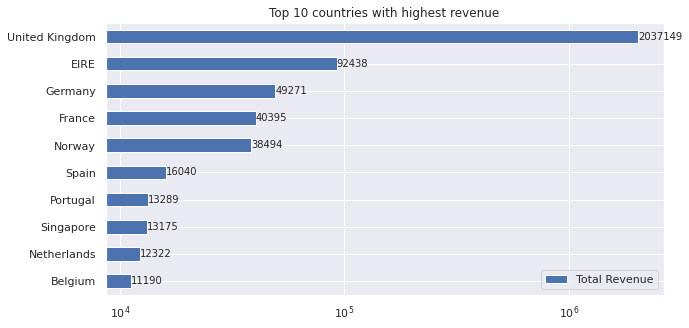

In [0]:
table.plot.barh(figsize=(10,5))
plt.title('Top 10 countries with highest revenue')
plt.xscale('log')
plt.xlabel('')
plt.ylabel('')
for i,index in enumerate(list(table.index)):
  label=(table.loc[index,'Total Revenue']).astype(int)
  plt.annotate(label,(label,i-0.1))


In [0]:
df_top10=df[df.country.isin(top_countries)]
table=df_top10.groupby(['country','year'])['price'].sum().reset_index()

Text(0.5, 1.0, 'Top 10 countries with highest revenue')

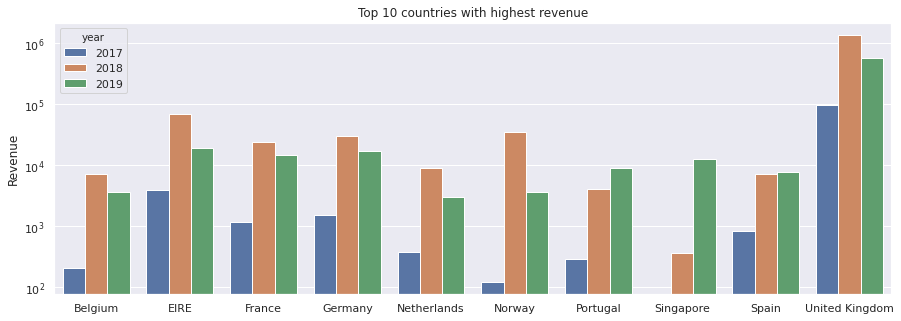

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=table,x='country',y='price',hue='year')
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Revenue')
plt.title('Top 10 countries with highest revenue')



* It is clear that the revenue from almost all top 10 countries declined since 2018 except for Portugal, Singapore and Spain. Then which countries' revenue has raised?


####4.2 Countries where the revenue has incresed since 2018

In [0]:
countries_2019=df.query('year==2019').country.to_list()
countries_2018=df.query('year==2018').country.to_list()
df_2019=df[df.country.isin(countries_2019) & df.country.isin(countries_2018)]

In [0]:
df_diff=pd.pivot_table(data=df_2019.query('year!=2017'),index=(['year','country']),values='price',aggfunc='sum')
df_diff.columns=['Total_Revenue']
df_diff

Total_Revenue
year country                            
2018 Australia                  4140.330
     Austria                    2356.520
     Bahrain                      91.560
     Belgium                    7291.000
     Brazil                      113.710
...                                  ...
2019 Switzerland                3793.330
     USA                          74.200
     United Arab Emirates         77.570
     United Kingdom           573384.352
     Unspecified                 634.490

[62 rows x 1 columns]

In [0]:
df_diff.reset_index().country.nunique()

31

In [0]:
df_diff.reset_index(inplace=True)
df_diff

,year,country,Total_Revenue
0,2018,Australia,4140.330
1,2018,Austria,2356.520
2,2018,Bahrain,91.560
3,2018,Belgium,7291.000
4,2018,Brazil,113.710
...,...,...,...
57,2019,Switzerland,3793.330
58,2019,USA,74.200
59,2019,United Arab Emirates,77.570
60,2019,United Kingdom,573384.352


In [0]:
list_reve_diff=df_diff.Total_Revenue.pct_change(periods=31)[31:]
list_country=df_diff.country.unique()

In [0]:
d = {'country': list_country , 'diff': list_reve_diff}
df_diff = pd.DataFrame(data=d)
df_diff=df_diff.query('diff>0').sort_values('diff')
df_diff.set_index(['country'],inplace=True)
df_diff

,diff
country,
Iceland,0.018928
Spain,0.078321
Brazil,0.254067
Finland,0.290929
Cyprus,0.374995
Poland,0.960242
Portugal,1.206347
Canada,5.139177
Singapore,33.370648


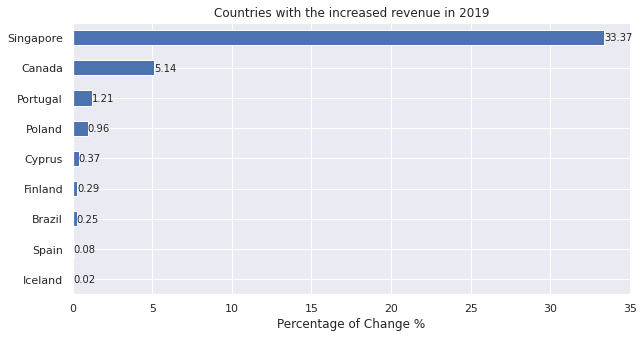

In [0]:
df_diff.plot.barh(figsize=(10,5))
plt.title('Countries with the increased revenue in 2019')
plt.xlabel('Percentage of Change %')
plt.ylabel('')
plt.legend().remove()
for i,index in enumerate(list(df_diff.index)):
  label=round((df_diff.loc[index,'diff']),2)
  plt.annotate(label,(label,i-0.1))


* It is clear that the revenue in 9 countries has increased since 2018 and three of them are among the top 10 countries with the highest revenue which are Portugal, Singapore and Spain

Text(0.5, 1.0, 'Days with purchase')

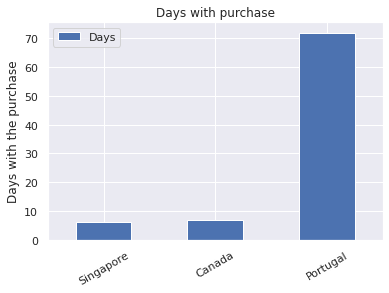

In [0]:
df_days_purchase=pd.DataFrame({'Country':['Singapore','Canada','Portugal'],
                               'Days':[df.query("country=='Singapore'").invoice_date.nunique(),
                                       df.query("country=='Canada'").invoice_date.nunique(),
                                       df.query("country=='Portugal'").invoice_date.nunique()]})
df_days_purchase.set_index('Country',inplace=True)
df_days_purchase.plot.bar()
plt.xlabel('')
plt.ylabel('Days with the purchase')
plt.xticks(rotation=30)
plt.title('Days with purchase')

The reasons why the countreis revenue increased is because there is not enough purchase in these countries. 

####4.3 The price change of the top 10 popular streams around the world

In [0]:
df.head()

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,invoice_date
1,United Kingdom,13085.0,489434,6.75,79323W,12.0,2017,11,28,2017-11-28
2,United Kingdom,13085.0,489434,2.10,22041,21.0,2017,11,28,2017-11-28
3,United Kingdom,13085.0,489434,1.25,21232,5.0,2017,11,28,2017-11-28
4,United Kingdom,13085.0,489434,1.65,22064,17.0,2017,11,28,2017-11-28
5,United Kingdom,13085.0,489434,1.25,21871,14.0,2017,11,28,2017-11-28


In [0]:
#Top 10 popular streams around the world
df_t10_st_w=df.groupby('stream_id')['times_viewed'].sum().reset_index().sort_values('times_viewed',ascending=False).head(10).reset_index(drop=True)
list_t10_st_w=df_t10_st_w.stream_id.to_list()
df_t10_st_w

,stream_id,times_viewed
0,85123A,33702.0
1,85099B,22700.0
2,84879,21239.0
3,21212,20733.0
4,20725,16974.0
5,21232,16372.0
6,84991,13455.0
7,22423,13320.0
8,21080,12395.0
9,22178,12215.0


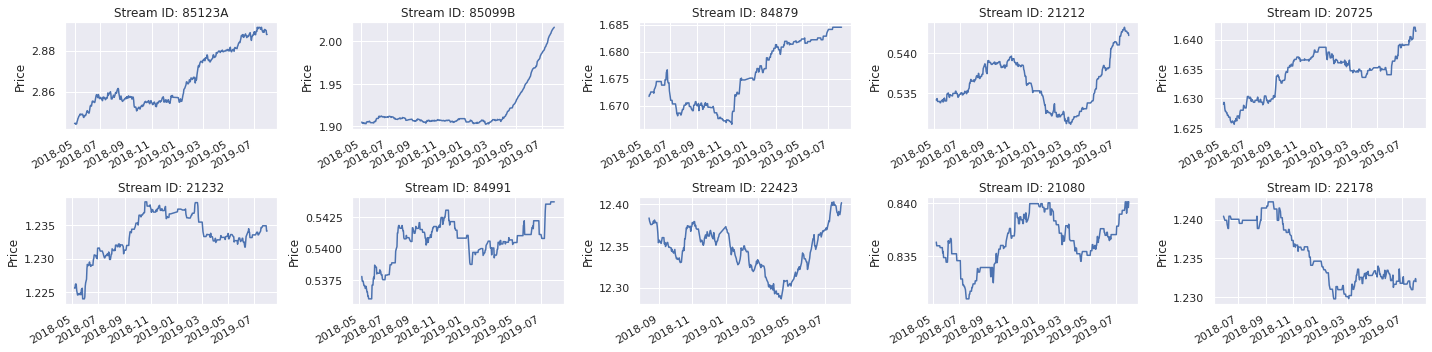

In [0]:
#Price changes during 2019
fig,ax=plt.subplots(2,5,figsize=(20,5))
for i in range(5):
  df[df.stream_id==list_t10_st_w[i]][['price','invoice_date']].groupby('invoice_date')['price'].mean().rolling(window=120).mean().plot(ax=ax[0][i])
  ax[0][i].set_title("Stream ID: "+list_t10_st_w[i])
  ax[0][i].set_xlabel('')
  ax[0][i].set_ylabel('Price')

for i in range(5,10):
  df[df.stream_id==list_t10_st_w[i]][['price','invoice_date']].groupby('invoice_date')['price'].mean().rolling(window=120).mean().plot(ax=ax[1][i-5])
  ax[1][i-5].set_title("Stream ID: "+list_t10_st_w[i])
  ax[1][i-5].set_xlabel('')
  ax[1][i-5].set_ylabel('Price')
plt.tight_layout()

* It is clear that the price of majority of the streams is increased during the year 2019. It indicates that the increased price may not be a major factor for the purchase. More details need to be ontained regarding the genres of the stream. The marketing team could recommend or advertise the popular genres to the target countries.

####4.4 Time Series information

In [0]:
# Creat function to generate time series information
def convert_to_ts(df_orig, country=None):
    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    list_dates=list(df.invoice_date.unique())
    list_n_purchase=list(df.groupby('invoice_date').count()['customer_id'].values)
    list_n_invoice=list(df.groupby('invoice_date').nunique()['invoice'].values)
    list_n_stream=list(df.groupby('invoice_date').nunique()['stream_id'].values)
    list_n_times_viewed=list(df.groupby('invoice_date')['times_viewed'].sum().values)
    list_n_revenue=list(df.groupby('invoice_date')['price'].sum().values)

    df_time = pd.DataFrame({'date':list_dates,
                           'purchases':list_n_purchase,
                           'unique_invoices':list_n_invoice,
                           'unique_streams':list_n_stream,
                           'total_views':list_n_times_viewed,
                           'revenue':list_n_revenue})
    df_time['year_month']=df_time.date.astype(str).str[:-3]
    return(df_time)


In [0]:
df_time=convert_to_ts(df)
df_time

,date,purchases,unique_invoices,unique_streams,total_views,revenue,year_month
0,2017-11-28,2307,137,1063,13285.0,7541.01,2017-11
1,2017-11-29,2304,120,1090,12111.0,6982.95,2017-11
2,2017-11-30,2408,137,1093,14541.0,9214.00,2017-11
3,2017-12-01,1965,93,1009,11319.0,5573.63,2017-12
4,2017-12-02,400,30,285,3310.0,1443.26,2017-12
...,...,...,...,...,...,...,...
490,2019-07-26,951,66,594,7145.0,2708.28,2019-07
491,2019-07-28,1262,42,784,6989.0,3092.25,2019-07
492,2019-07-29,1002,42,654,6609.0,3460.66,2019-07
493,2019-07-30,948,56,664,7384.0,2781.47,2019-07


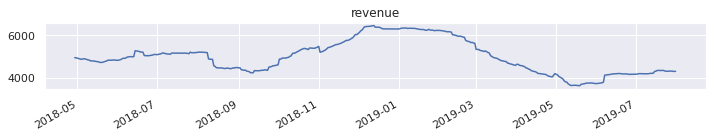

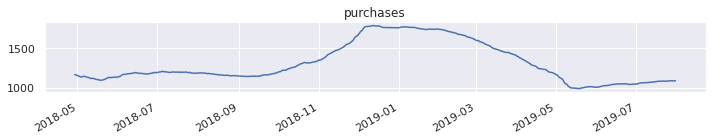

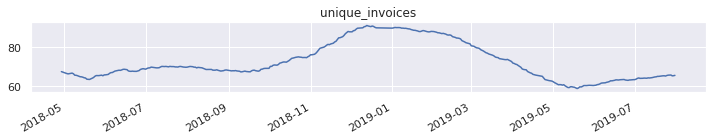

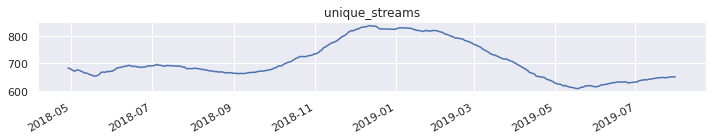

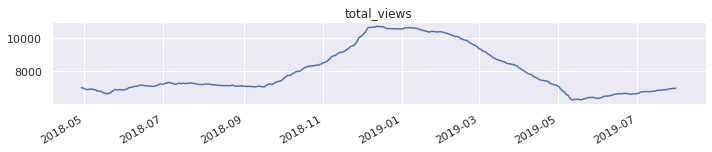

In [0]:
col_all=['revenue','purchases','unique_invoices','unique_streams','total_views']
df_time.set_index('date',inplace=True)
for i, col in enumerate(col_all):
  plt.figure(figsize=(10,8))
  plt.subplot(5,1,i+1)
  df_time[col].rolling(window=120).mean().plot(x='date')
  plt.title(col)
  plt.xlabel('')
  plt.tight_layout()

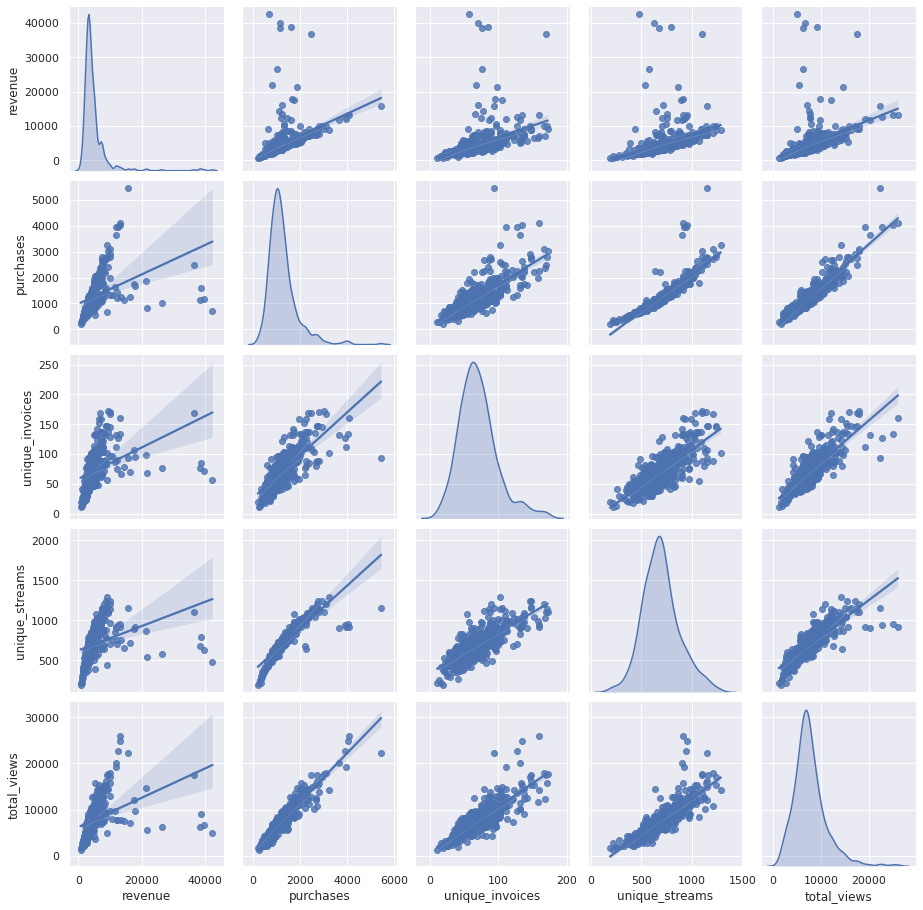

In [0]:
sns.pairplot(data=df_time, 
             vars=col_all,
             kind='reg',
             diag_kind='kde')

* It is clear that the all features reached the peak in January 2019 then gradually declined. All features are also positively related

####4.5 Extract time series data from top 10 countries

In [0]:
# Store top 10 countries time series information
df_time_all = {}
df_time_all['all'] = convert_to_ts(df)
for country in top_countries:
    df_time_all[country] = convert_to_ts(df,country=country)


In [0]:
df_time_all


{'Belgium':           date  purchases  unique_invoices  ...  total_views  revenue  year_month
 0   2017-11-28          1                1  ...          1.0   130.00     2017-11
 1   2017-12-03         18                1  ...        123.0    78.25     2017-12
 2   2017-12-07          1                1  ...         10.0     0.85     2017-12
 3   2018-01-05         27                1  ...        190.0   121.40     2018-01
 4   2018-01-10          1                1  ...          3.0     9.95     2018-01
 ..         ...        ...              ...  ...          ...      ...         ...
 104 2019-07-04         20                2  ...        143.0    96.71     2019-07
 105 2019-07-10          2                1  ...         13.0    17.55     2019-07
 106 2019-07-24         70                1  ...        528.0   247.49     2019-07
 107 2019-07-25          4                1  ...         30.0    22.72     2019-07
 108 2019-07-30         39                1  ...        242.0   171.80     2

#### 4.6 Creat functions to fetch the data from file

In [0]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """
    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']


    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    ## clean the date
    df['invoice_date']=(df.year.astype(str)+'-'+df.month.astype(str)+'-'+df.day.astype(str)).astype('datetime64')
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)


# Creat function to generate time series information
def convert_to_ts(df_orig, country=None):
    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    list_dates=list(df.invoice_date.unique())
    list_n_purchase=list(df.groupby('invoice_date').count()['customer_id'].values)
    list_n_invoice=list(df.groupby('invoice_date').nunique()['invoice'].values)
    list_n_stream=list(df.groupby('invoice_date').nunique()['stream_id'].values)
    list_n_times_viewed=list(df.groupby('invoice_date')['times_viewed'].sum().values)
    list_n_revenue=list(df.groupby('invoice_date')['price'].sum().values)

    df_time = pd.DataFrame({'date':list_dates,
                           'purchases':list_n_purchase,
                           'unique_invoices':list_n_invoice,
                           'unique_streams':list_n_stream,
                           'total_views':list_n_times_viewed,
                           'revenue':list_n_revenue})
    df_time['year_month']=df_time.date.astype(str).str[:-3]
    return(df_time)



def fetch_ts(data_dir, clean=False):
    """
    convenience function to read in new data
    uses csv to load quickly
    use clean=True when you want to re-create the files
    """

    ## get original data
    print("... processing data for loading")
    df = fetch_data(data_dir)

    ## find the top ten countries (wrt revenue)
    table=pd.pivot_table(data=df,index='country',values='price',aggfunc='sum')
    table.columns=['Total Revenue']
    table.sort_values('Total Revenue',inplace=True)
    table=table.tail(10)
    top_countries=table.index


    ## load the data
    df_time_all = {}
    df_time_all['all'] = convert_to_ts(df)
    for country in top_countries:
      df_time_all[country] = convert_to_ts(df,country=country)


    ## save the data as csvs    
    for key, item in dfs.items():
        item.to_csv(os.path.join(ts_data_dir,"ts-"+key+".csv"),index=False)
        
    return(df_time_all)

## Part 5 Feature Engineering<a name="feature"></a>
We could engineer features with revenue for the previous day, previous week, previous month, previous three months and previous year

In [0]:
def engineer_features(df,training=True):
    ## extract dates
    df.reset_index(inplace=True)
    dates = df['date'].values.copy()
    dates = dates.astype('datetime64[D]')
    ## engineer some features
    eng_features = defaultdict(list)
    previous =[7, 14, 28, 70]  #[7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
    y = np.zeros(dates.size)
    for d,day in enumerate(dates):
        ## use windows in time back from a specific date
        for num in previous:
            current = np.datetime64(day, 'D') 
            prev = current - np.timedelta64(num, 'D')
            mask = np.in1d(dates, np.arange(prev,current,dtype='datetime64[D]'))
            eng_features["previous_{}".format(num)].append(df[mask]['revenue'].sum())

        ## get get the target revenue    
        plus_30 = current + np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(current,plus_30,dtype='datetime64[D]'))
        y[d] = df[mask]['revenue'].sum()

        ## attempt to capture monthly trend with previous years data (if present)
        start_date = current - np.timedelta64(365,'D')
        stop_date = plus_30 - np.timedelta64(365,'D')
        mask = np.in1d(dates, np.arange(start_date,stop_date,dtype='datetime64[D]'))
        eng_features['previous_year'].append(df[mask]['revenue'].sum()) #

        ## add some non-revenue features
        minus_30 = current - np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(minus_30,current,dtype='datetime64[D]'))
        eng_features['recent_invoices'].append(df[mask]['unique_invoices'].mean())
        eng_features['recent_views'].append(df[mask]['total_views'].mean())

    X = pd.DataFrame(eng_features)
    ## combine features in to df and remove rows with all zeros
    X.fillna(0,inplace=True)
    mask = X.sum(axis=1)>0
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)

    if training == True:
        ## remove the last 30 days (because the target is not reliable)
        mask = np.arange(X.shape[0]) < np.arange(X.shape[0])[-30]
        X = X[mask]
        y = y[mask]
        dates = dates[mask]
        X.reset_index(drop=True, inplace=True)
    
    return(X,y,dates)

In [0]:
X,y,dates=engineer_features(df_time)

## Part 6 Modelling<a name="modelling"></a>

In [0]:
import time,os,re,csv,sys,uuid,joblib
from datetime import date
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)

### 3.1 Random Forest

In [0]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [0]:
## train a random forest model
param_grid_rf = {
    'rf__criterion': ['mse','mae'],
    'rf__n_estimators': [10,15,20]
    }


pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                          ('rf', RandomForestRegressor())])
    
grid = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
eval_rmse =  round(np.sqrt(mean_squared_error(y_test,y_pred)))
print('RMSE = %f' % eval_rmse)


RMSE = 17580.000000


### 3.2 Gaussian Processes

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared as ES
from sklearn.gaussian_process.kernels import DotProduct as DP
from sklearn.gaussian_process.kernels import Matern 
from sklearn.gaussian_process.kernels import WhiteKernel as WK

l = 2.
kernels = {'cnt': C(constant_value=0.1),
           'rbf': RBF(length_scale=l),
           'ex2': ES(length_scale=l),
           'dot': DP(sigma_0=0.1),
           'mat': Matern(length_scale=l , nu=1.5),
           'whi': WK(noise_level=0.01)}
           
k = kernels['cnt'] + kernels['ex2'] + kernels['rbf'] 
if 'gp' in locals(): del gp

# Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)
# Predict
pipe_gp = Pipeline(steps=[('scaler', StandardScaler()),
                          ('gp', GP(kernel=k, n_restarts_optimizer=9, normalize_y=True))])


pipe_gp.fit(X_train, y_train)
gp_y_fit = pipe_gp.predict(X_train, return_std=False)
gp_y_pred, gp_y_std = pipe_gp.predict(X_test, return_std=True)


# Calculating Errors
gp_rmse = round(np.sqrt(mean_squared_error(y_test,gp_y_pred)))
print('RMSE = %f' % gp_rmse)


RMSE = 14445.000000


### 3.3 Creat a function for modelling

In [0]:
## model specific variables (iterate the version and note with each change)
MODEL_DIR = "models"
MODEL_VERSION = 0.1
MODEL_VERSION_NOTE = "supervised learing model for time-series"

def _model_train(df,tag,test=False):
    """
    example funtion to train model
    
    The 'test' flag when set to 'True':
        (1) subsets the data and serializes a test version
        (2) specifies that the use of the 'test' log file 
    """


    ## start timer for runtime
    time_start = time.time()
    
    X,y,dates = engineer_features(df)

    if test:
        n_samples = int(np.round(0.3 * X.shape[0]))
        subset_indices = np.random.choice(np.arange(X.shape[0]),n_samples,
                                          replace=False).astype(int)
        mask = np.in1d(np.arange(y.size),subset_indices)
        y=y[mask]
        X=X[mask]
        dates=dates[mask]
        
    ## Perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)
    ## train a random forest model
    param_grid_rf = {
    'rf__criterion': ['mse','mae'],
    'rf__n_estimators': [10,15,20,25]
    }

    pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                              ('rf', RandomForestRegressor())])
    
    grid = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, iid=False, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    eval_rmse =  round(np.sqrt(mean_squared_error(y_test,y_pred)))
    
    ## retrain using all data
    grid.fit(X, y)
    model_name = re.sub("\.","_",str(MODEL_VERSION))

    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)

    ## update log
    update_train_log(tag,(str(dates[0]),str(dates[-1])),{'rmse':eval_rmse},runtime,
                     MODEL_VERSION, MODEL_VERSION_NOTE,test=True)
  

def model_train(data_dir,test=False):
    """
    funtion to train model given a df
    
    'mode' -  can be used to subset data essentially simulating a train
    """
        
    ## fetch time-series formatted data
    ts_data = fetch_ts(data_dir)

    ## train a different model for each data sets
    for country,df in ts_data.items():
        
        if test and country not in ['all','united_kingdom']:
            continue
        
        _model_train(df,country,test=test)
    
def model_load(prefix='sl',data_dir=None,training=True):


    ## load data
    ts_data = fetch_ts(data_dir)
    all_data = {}
    for country, df in ts_data.items():
        X,y,dates = engineer_features(df,training=training)
        dates = np.array([str(d) for d in dates])
        all_data[country] = {"X":X,"y":y,"dates": dates}
        
    return(all_data, all_models)

def model_predict(country,year,month,day,all_models=None,test=False):
    ## load data
    model = all_models[country]
    data = all_data[country]

    ## check date
    target_date = "{}-{}-{}".format(year,str(month).zfill(2),str(day).zfill(2))
    print(target_date)

    if target_date not in data['dates']:
        raise Exception("ERROR (model_predict) - date {} not in range {}-{}".format(target_date,
                                                                                    data['dates'][0],
                                                                                    data['dates'][-1]))
    date_indx = np.where(data['dates'] == target_date)[0][0]
    query = data['X'].iloc[[date_indx]]
    
    ## sainty check
    if data['dates'].shape[0] != data['X'].shape[0]:
        raise Exception("ERROR (model_predict) - dimensions mismatch")

    ## make prediction and gather data for log entry
    y_pred = model.predict(query)
    y_proba = None
    if 'predict_proba' in dir(model) and 'probability' in dir(model):
        if model.probability == True:
            y_proba = model.predict_proba(query)


    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)

    ## update predict log
    update_predict_log(country,y_pred,y_proba,target_date,
                       runtime, MODEL_VERSION, test=test)
    
    return({'y_pred':y_pred,'y_proba':y_proba})